# Investigate how network width and depths impact performance

## Main Questions

* Are two layers enough?
* Do we need wide networks?

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from aimanager.utils.utils import make_dir
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

run = 'mlp_parameter'

folder = f'../../data/training/{run}/train'
merged_folder = f'../../data/training/{run}/merged'
bs_folder = f'../../data/training/baselines/train'
bs_merged_folder = f'../../data/training/baselines/merged'

plot_folder = f'plots/{run}'

make_dir(plot_folder)
make_dir(merged_folder)
make_dir(bs_merged_folder)

In [2]:
# file_names = ['metrics.parquet', 'confusion_matrix.parquet', 'synthetic_predicitions.parquet']
file_names = ['metrics.parquet']


def get_df(file_name, merged_folder, folder):
    m_file = os.path.join(merged_folder, file_name)
    if not os.path.isfile(m_file):
        df = merge_files_by_name(folder, file_name)
        df.to_parquet(m_file)
        return df
    else:
        return pd.read_parquet(m_file)

metrics_df, = (
    get_df(file_name, merged_folder, folder)
    for file_name in file_names
)

baseline_df = get_df(file_names[0], bs_merged_folder, bs_folder)

In [3]:
baseline_df

,baseline,name,value,cv_split,epoch,set,strategy
0,onehot_mlp,loss,3.086031,0,0,None,None
1,onehot_mlp,mean_absolute_error,8.987950,0,0,train,None
2,onehot_mlp,accuracy,0.035976,0,0,train,None
3,onehot_mlp,mean_absolute_error,10.737342,0,0,test,None
4,onehot_mlp,accuracy,0.031646,0,0,test,None
...,...,...,...,...,...,...,...
17995,onehot_mlp_graph_2,accuracy,0.351380,19,990,train,sampling
17996,onehot_mlp_graph_2,mean_absolute_error,3.013699,19,990,test,greedy
17997,onehot_mlp_graph_2,accuracy,0.479452,19,990,test,greedy
17998,onehot_mlp_graph_2,mean_absolute_error,3.876712,19,990,test,sampling


In [4]:
labels = list(set(metrics_df.columns) - set(['name', 'value', 'cv_split', 'epoch', 'set']))
print(labels)

metrics_df['label'] = ''
bw = ''
for l in labels:
    metrics_df['label'] += (bw + l + ':') + metrics_df[l].astype(str)
    bw = ' '

to_string = ['layers', 'hidden_size']
to_string = list(set(to_string).intersection(set(metrics_df.columns)))
if len(to_string) > 0:
    metrics_df[to_string] = metrics_df[to_string].astype(str)
    # synthethetic_df[to_string] = synthethetic_df[to_string].astype(str)
    # confusion_matrix_df[to_string] = confusion_matrix_df[to_string].astype(str)

['hidden_size', 'lr', 'layers', 'strategy', 'fraction_training', 'regularisation']


In [5]:
w = (
    (baseline_df['set'] == 'test') & 
    (baseline_df['epoch'] == 990) & 
    (baseline_df['strategy'] == 'greedy') & 
    (baseline_df['baseline'] == 'onehot_mlp_graph_2') 
)

df = baseline_df[w]

baseline = df.groupby(['baseline', 'name'])['value'].median()
baseline

baseline            name               
onehot_mlp_graph_2  accuracy               0.489726
                    mean_absolute_error    2.867874
Name: value, dtype: float64

## Overview

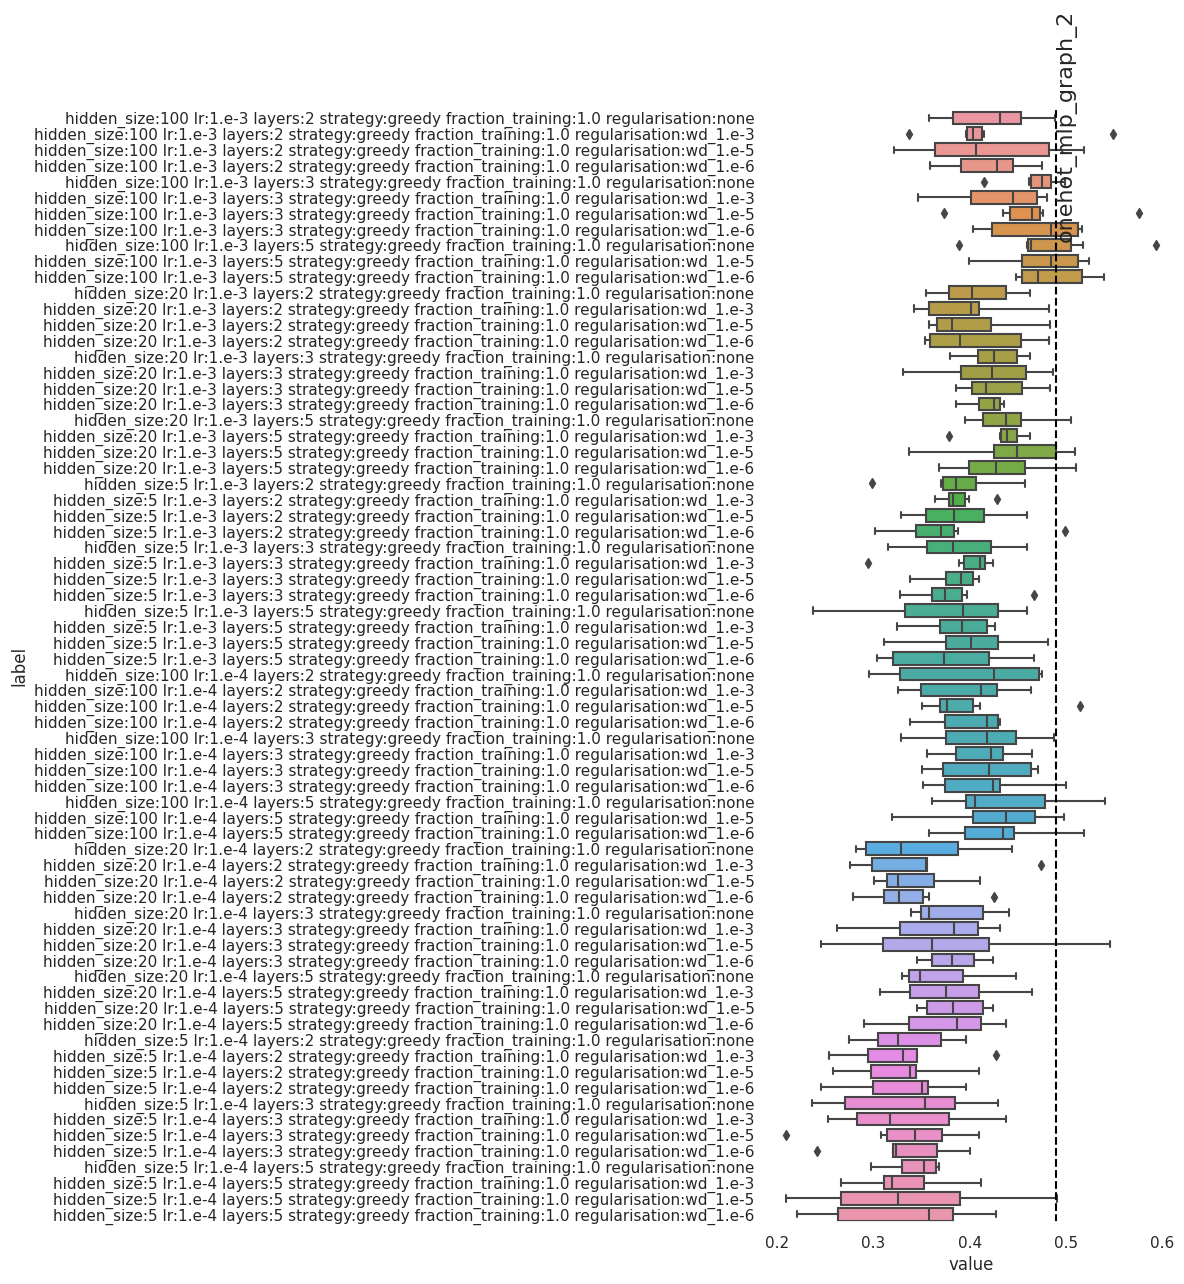

In [11]:
metric_name = 'accuracy'

w1 = (
    (metrics_df['set'] == 'test') & 
    (metrics_df['strategy'] == 'greedy') & 
    (metrics_df['fraction_training'] == 1) & 
    (metrics_df['epoch'] == 990)
)

w2 = (metrics_df['name'] == metric_name)
df = metrics_df[w1 & w2]

df = df.sort_values(['lr', 'hidden_size', 'layers', 'regularisation'])
sns.catplot(data=df, x='value', y='label', orient='h', kind='box', sharex=False, height=12)

for idx, dfg in baseline.groupby(level=0):
    plt.axvline(dfg[(idx, metric_name)], color='black', ls='--')
    plt.text(dfg[(idx, metric_name)], 0.5, idx, rotation=90, size=16, va='center')

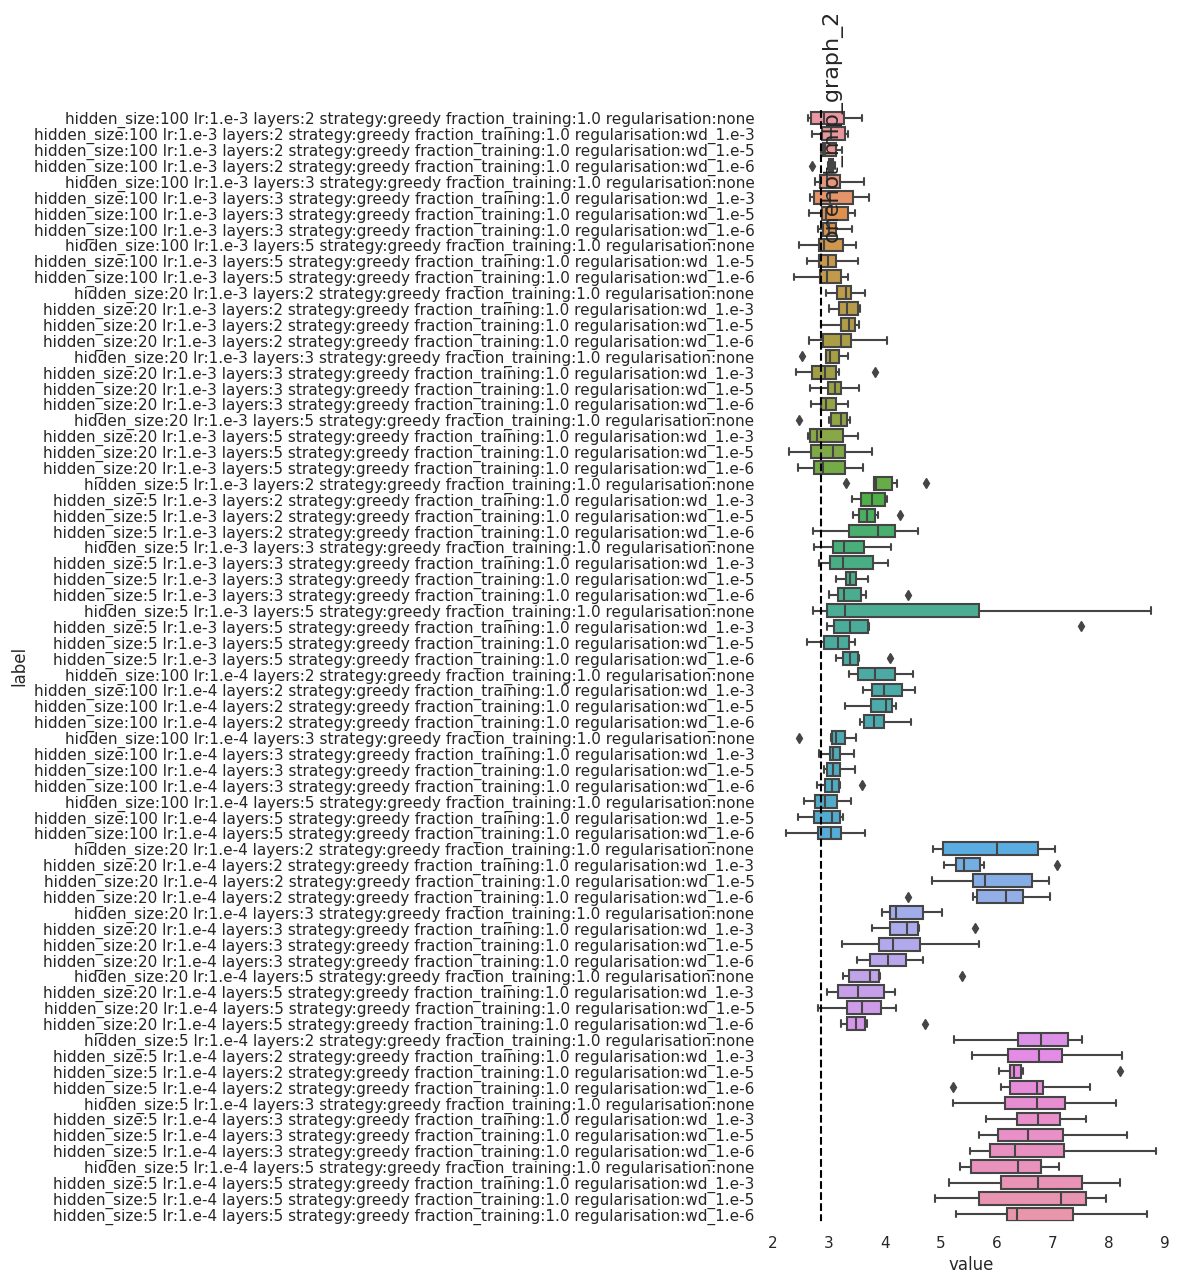

In [12]:
metric_name = 'mean_absolute_error'
w2 = (metrics_df['name'] == metric_name)
df = metrics_df[w1 & w2]

df = df.sort_values(['lr', 'hidden_size', 'layers', 'regularisation'])
sns.catplot(data=df, x='value', y='label', orient='h', kind='box', sharex=False, height=12)

for idx, dfg in baseline.groupby(level=0):
    plt.axvline(dfg[(idx, metric_name)], color='black', ls='--')
    plt.text(dfg[(idx, metric_name)], 0.5, idx, rotation=90, size=16, va='center')

In [13]:
df.head()

,fraction_training,hidden_size,layers,lr,regularisation,name,value,cv_split,epoch,set,strategy,label
896,1.0,100,2,1.e-3,none,mean_absolute_error,2.634497,0,990,test,greedy,hidden_size:100 lr:1.e-3 layers:2 strategy:gre...
1796,1.0,100,2,1.e-3,none,mean_absolute_error,2.988131,1,990,test,greedy,hidden_size:100 lr:1.e-3 layers:2 strategy:gre...
2696,1.0,100,2,1.e-3,none,mean_absolute_error,3.585049,2,990,test,greedy,hidden_size:100 lr:1.e-3 layers:2 strategy:gre...
3596,1.0,100,2,1.e-3,none,mean_absolute_error,3.361789,3,990,test,greedy,hidden_size:100 lr:1.e-3 layers:2 strategy:gre...
4496,1.0,100,2,1.e-3,none,mean_absolute_error,2.829710,4,990,test,greedy,hidden_size:100 lr:1.e-3 layers:2 strategy:gre...


### First conclusion

* Hugh variance in the performance
* Numeric encoding has clearly lower performance

## Statistical analysis of grid

In [16]:
label_ref = {
    # 'fraction_training': 1,
    'regularisation': 'none',
    'layers': 2,
    'hidden_size': 5,
    'lr': '1.e-4'
}

label_str = [f"C({l}, Treatment(reference='{label_ref[l]}'))" if l in label_ref else l for l in labels]

In [18]:
w = (
    (metrics_df['name'] == 'accuracy') &
    (metrics_df['set'] == 'test') &
    (metrics_df['strategy'] == 'greedy') & 
    # (metrics_df['layers'] == '2') & 
    (metrics_df['epoch'] == 990)
)
df = metrics_df[w]

m_str = [f'{a}*{b}' for a in label_str for b in label_str]

results = smf.glm(f"value ~ {'+'.join(m_str)}", data=df).fit()
results_df = results.summary2().tables[1]

print('metric accuracy - positive coef -> better')
results_df[results_df['P>|z|'] < 0.25].sort_values('P>|z|')


metric accuracy - positive coef -> better


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,0.186168,0.014482,12.855362,8.024931e-38,0.157785,0.214552
"C(lr, Treatment(reference='1.e-4'))[T.1.e-3]",0.135301,0.011956,11.316813,1.083396e-29,0.111868,0.158734
"C(hidden_size, Treatment(reference='5'))[T.100]",0.142798,0.014212,10.047847,9.389634e-24,0.114944,0.170653
fraction_training,0.150777,0.017681,8.527590,1.494281e-17,0.116123,0.185431
"C(hidden_size, Treatment(reference='5'))[T.20]",0.109648,0.013911,7.882376,3.212134e-15,0.082384,0.136913
"C(hidden_size, Treatment(reference='5'))[T.100]:C(lr, Treatment(reference='1.e-4'))[T.1.e-3]",-0.054114,0.008187,-6.609882,3.846261e-11,-0.070160,-0.038068
"C(lr, Treatment(reference='1.e-4'))[T.1.e-3]:fraction_training",-0.067584,0.011813,-5.721142,1.058105e-08,-0.090738,-0.044431
"C(hidden_size, Treatment(reference='5'))[T.100]:C(layers, Treatment(reference='2'))[T.5]",0.057222,0.010189,5.616081,1.953367e-08,0.037252,0.077192
"C(hidden_size, Treatment(reference='5'))[T.20]:fraction_training",-0.079804,0.014349,-5.561776,2.670432e-08,-0.107926,-0.051681
"C(hidden_size, Treatment(reference='5'))[T.100]:fraction_training",-0.075500,0.014615,-5.166026,2.391239e-07,-0.104145,-0.046856


### Accuracy

#### Strong evidence
* larger learning rate (1.e-3) is better
* ordinal x encoding (and to a lesser extend onehot) is better then numeric encoding
* higher number of neurons is better for onehot encodingß

In [20]:
w = (
    (metrics_df['name'] == 'mean_absolute_error') &
    (metrics_df['set'] == 'test') &
    (metrics_df['strategy'] == 'sampling') &
    (metrics_df['epoch'] == 990)
)
df = metrics_df[w]

m_str = [f'{a}*{b}' for a in label_str for b in label_str]

results = smf.glm(f"value ~ {'+'.join(m_str)}", data=df).fit()
results_df = results.summary2().tables[1]

print('metric mean_absolute_error - negative coef -> better')
results_df[results_df['P>|z|'] < 0.10].sort_values('Coef.')

metric mean_absolute_error - negative coef -> better


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
"C(lr, Treatment(reference='1.e-4'))[T.1.e-3]",-3.284987,0.084527,-38.863116,0.000000e+00,-3.450657,-3.119317
"C(hidden_size, Treatment(reference='5'))[T.100]",-2.974251,0.100478,-29.601126,1.445246e-192,-3.171184,-2.777319
fraction_training,-1.724494,0.125005,-13.795393,2.716691e-43,-1.969500,-1.479489
"C(hidden_size, Treatment(reference='5'))[T.20]",-1.159802,0.098348,-11.792874,4.247933e-32,-1.352560,-0.967044
"C(hidden_size, Treatment(reference='5'))[T.20]:C(layers, Treatment(reference='2'))[T.5]",-0.764052,0.069681,-10.965056,5.626585e-28,-0.900624,-0.627481
"C(hidden_size, Treatment(reference='5'))[T.100]:C(layers, Treatment(reference='2'))[T.5]",-0.667223,0.072036,-9.262357,1.999684e-20,-0.808412,-0.526035
"C(layers, Treatment(reference='2'))[T.5]",-0.447772,0.100295,-4.464555,8.023528e-06,-0.644346,-0.251197
"C(hidden_size, Treatment(reference='5'))[T.100]:C(layers, Treatment(reference='2'))[T.3]",-0.412227,0.069680,-5.915961,3.299434e-09,-0.548798,-0.275656
"C(hidden_size, Treatment(reference='5'))[T.20]:C(layers, Treatment(reference='2'))[T.3]",-0.397548,0.069680,-5.705294,1.161427e-08,-0.534119,-0.260976
"C(layers, Treatment(reference='2'))[T.3]",-0.383172,0.098110,-3.905550,9.401146e-05,-0.575463,-0.190881


### mean absolute error

#### Strong evidence
* ordinal > numeric
* hidden 20 > hidden 5

## Best parameters

In [21]:
# w = (
#     (metrics_df['x_encoding'] == 'numeric')
# )
# df = metrics_df[w]
df = metrics_df

best_labels = {}
for m in ['mean_absolute_error', 'accuracy']:
    df = df.reset_index(drop=True)
    gb_col = list(set(df.columns) - set(['cv_split', 'value']))
    df_g = df.groupby(gb_col)['value'].median().reset_index()
    df_g = df_g.dropna(subset='value')
    w = (
        (df_g['name'] == m) &
        (df_g['set'] == 'test')
    )
    if m == 'mean_absolute_error':
        best = df_g.loc[df_g[w]['value'].idxmin()]
    else:
        best = df_g.loc[df_g[w]['value'].idxmax()]
    best_labels[m] = {l: best[l] for l in labels}

    print(f'Best performance for metric {m} is {best.label}.')
    w = (
        (df_g['label'] == best.label) &
        (df_g['epoch'] == 990)
    )

    print(df_g.loc[w, ['name', 'set', 'value']])
    print('================')
    # print(f'Best performance for metric {m} with a value of {best.value} is {best.label} in epoch {best.epoch}')



Best performance for metric mean_absolute_error is hidden_size:20 lr:1.e-3 layers:5 strategy:greedy fraction_training:0.75 regularisation:wd_1.e-5.
                       name    set     value
86998              accuracy   test  0.446544
86999              accuracy  train  0.433336
124998  mean_absolute_error   test  2.970229
124999  mean_absolute_error  train  3.004823
Best performance for metric accuracy is hidden_size:100 lr:1.e-3 layers:5 strategy:greedy fraction_training:0.75 regularisation:none.
                      name    set     value
14598             accuracy   test  0.501740
14599             accuracy  train  0.486800
50598  mean_absolute_error   test  3.072314
50599  mean_absolute_error  train  2.998046


### Summary

* We have the highest accuracy and mae for
    * low regularisation 
    * hidden_size of 20
    * learning rate of 1.e-3
    * x-encoding onehot
* 3 layer is leading to a better mae, 2 layer to a higher accuracy

## Investigation of particular parameter

### Hidden Size and number of layer

lr=1.e-3|strategy=greedy|fraction_training=0.75|regularisation=wd_1.e-5|epoch=990


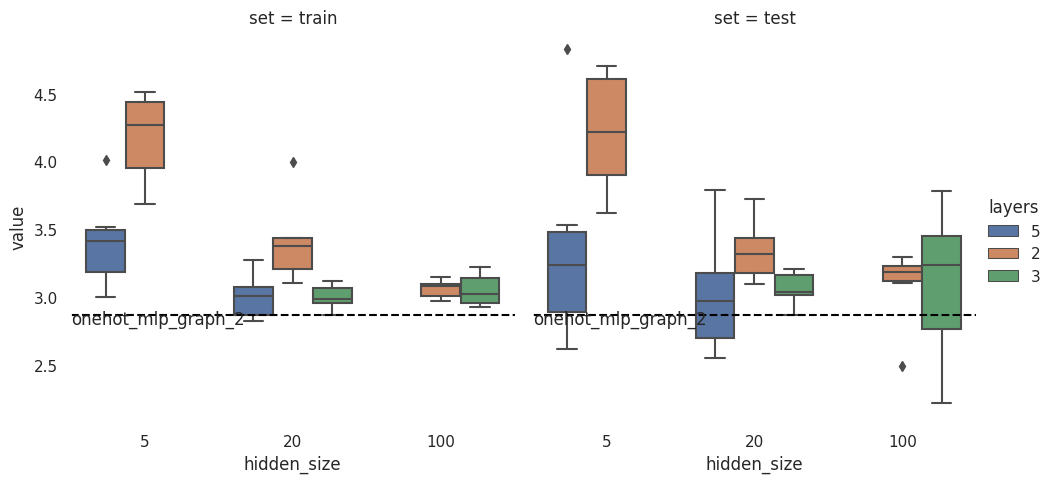

In [23]:
selection = best_labels['mean_absolute_error'].copy()

focus = ['hidden_size', 'layers']
metric_name = 'mean_absolute_error'

for f in focus:
    selection.pop(f)
selection['epoch'] = 990

w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.catplot(data=metrics_df[w1 & w2], x=focus[0], hue=focus[1], y='value', col='set', kind='box', sharey=True)

for idx, dfg in baseline.groupby(level=0):
    for ax in fg.axes_dict.values():
        ax.axhline(dfg[(idx, metric_name)], color='black', ls='--')
        ax.text(-0.5, dfg[(idx, metric_name)]*0.99,  idx, rotation=0, size=12, va='center')

print('|'.join(f'{k}={v}' for k, v in selection.items()))

#### Results

* Number of layers has a relative small effect on mae
* Number of hidden units has a large effect on the training set and a small effect on the test set (overfitting!)

lr=1.e-3|layers=5|strategy=greedy|regularisation=wd_1.e-5|epoch=990


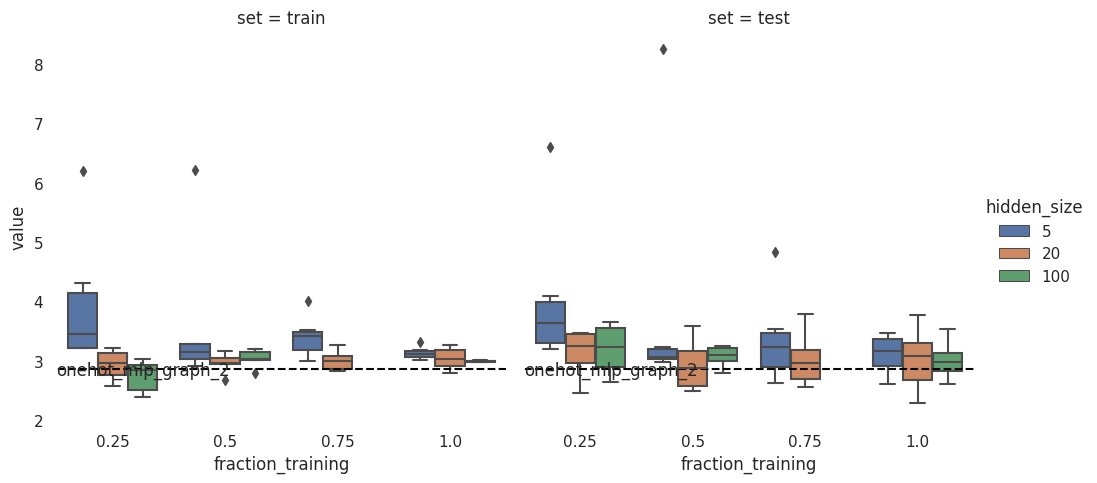

In [26]:
metric_name = 'mean_absolute_error'

selection = best_labels[metric_name].copy()

focus = ['fraction_training', 'hidden_size']


for f in focus:
    selection.pop(f)
selection['epoch'] = 990

w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.catplot(data=metrics_df[w1 & w2], x=focus[0], hue=focus[1], y='value', col='set', kind='box', sharey=True)

for idx, dfg in baseline.groupby(level=0):
    for ax in fg.axes_dict.values():
        ax.axhline(dfg[(idx, metric_name)], color='black', ls='--')
        ax.text(-0.5, dfg[(idx, metric_name)]*0.99,  idx, rotation=0, size=12, va='center')

print('|'.join(f'{k}={v}' for k, v in selection.items()))